# Comparative Analysis of CNN and Transfer Learning for Flower Image Classification

This project is part of an image classification approach applied to a dataset composed of photographs of four different flower species. The objective is to design, evaluate, and compare several convolutional neural network (CNN) approaches in order to analyze their ability to visually discriminate between these classes.

# I- Data preparation 

## 1. Data load 

In [7]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import AUTOTUNE

# Detect project root
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "data" / "jpg"

# Load datasets
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=16
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=16
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Optimize input pipeline
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 320 files belonging to 4 classes.
Using 256 files for training.


Found 320 files belonging to 4 classes.
Using 64 files for validation.


## 2. Data augmentation 

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


# II-Baseline CNN

## 1. Architecture and Training




In [11]:
model = models.Sequential([

    layers.Input(shape=(128, 128, 3)),

    # Normalize pixel values to [0,1]
    layers.Rescaling(1./255),

    # Data augmentation
    data_augmentation,

    # ---------------- Block 1 ----------------
    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # ---------------- Block 2 ----------------
    layers.Conv2D(128, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(128, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # ---------------- Block 3 ----------------
    layers.Conv2D(256, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # ---------------- Block 4 ----------------
    layers.Conv2D(256, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # Global pooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Classification head
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 1,282,628 (4.89 MB)

 Trainable params: 1,280,836 (4.89 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6562 - loss: 0.8279 - val_accuracy: 0.3281 - val_loss: 1.3333
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8125 - loss: 0.5577 - val_accuracy: 0.5156 - val_loss: 0.8660
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7969 - loss: 0.5809 - val_accuracy: 0.2969 - val_loss: 1.7317
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8242 - loss: 0.4786 - val_accuracy: 0.4062 - val_loss: 1.2338
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.8281 - loss: 0.4425 - val_accuracy: 0.4531 - val_loss: 1.4259
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8086 - loss: 0.5378 - val_accuracy: 0.4844 - val_loss: 1.4958
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8438 - loss: 0.4598 - val_accuracy: 0.4062 - val_loss: 1.6644


This code defines a CNN for 128×128 image classification.

Images are first normalized and augmented using data augmentation.
The model consists of four convolutional blocks with Conv2D, Batch Normalization, ReLU activation, and MaxPooling, with increasing filters (64 → 256).

A GlobalAveragePooling layer reduces the spatial dimensions before a 512-unit dense layer with Dropout, followed by a softmax output layer for multi-class classification.

The model is compiled with Adam and trained using early stopping to prevent overfitting.

## 2. Model Evaluation and Performance Analysis


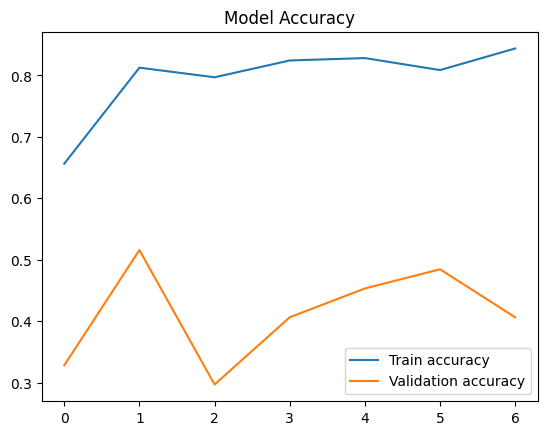

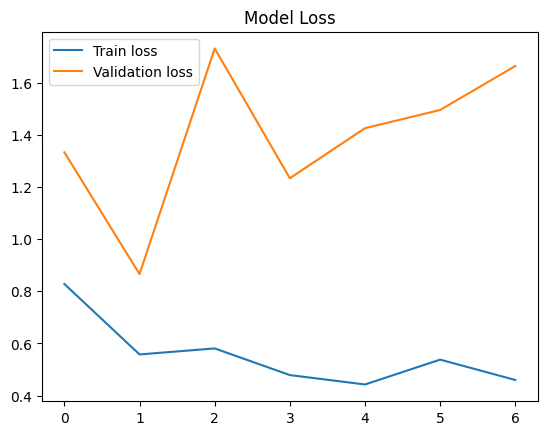

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
Confusion Matrix:
[[10  9  0  0]
 [ 0 18  1  0]
 [ 1  8  4  0]
 [11  1  0  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.53      0.49        19
           2       0.50      0.95      0.65        19
           4       0.80      0.31      0.44        13
           9       1.00      0.08      0.14        13

    accuracy                           0.52        64
   macro avg       0.69      0.46      0.43        64
weighted avg       0.65      0.52      0.46        64



2026-02-15 23:03:43.424505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Learning curves
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Model Loss")
plt.show()

# Confusion matrix and classification report
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


The model shows clear signs of overfitting: while training loss decreases steadily, validation loss increases and validation accuracy remains unstable. This is likely due to the relatively small dataset compared to the model capacity (1.28M parameters). Additional regularization or more data would be required to improve generalization.

The confusion matrix reveals uneven class performance. While class 2 is correctly classified with high recall (0.95), class 9 is almost never correctly predicted (recall 0.08). The macro F1-score (0.43) indicates poor balanced performance across classes. This confirms the presence of overfitting and limited generalization, likely due to the small dataset size relative to model capacity.

To improve the results, several strategies could be explored. First, stronger regularization could be applied by reducing model capacity (e.g., decreasing the size of the dense layer), increasing dropout, or lowering the learning rate. Second, more aggressive data augmentation could help improve generalization. Finally, collecting more training data or using transfer learning with a pretrained model could significantly enhance performance and class balance.

## 3. Improvement 

In [ ]:
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf

# Stronger data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

model = models.Sequential([

    layers.Input(shape=(128, 128, 3)),

    # Normalize inputs
    layers.Rescaling(1./255),

    # Data augmentation
    data_augmentation,

    # -------- Block 1 --------
    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # -------- Block 2 --------
    layers.Conv2D(128, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # -------- Block 3 --------
    layers.Conv2D(256, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # -------- Block 4 --------
    layers.Conv2D(256, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),

    # Reduced dense layer (less capacity)
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),

    layers.Dense(num_classes, activation="softmax")
])

# Lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stop, reduce_lr]
)



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,030,532 (3.93 MB)

 Trainable params: 1,029,124 (3.93 MB)

 Non-trainable params: 1,408 (5.50 KB)

# II- Transfer Learning with DenseNet121

## 1. Architecture and Training

In [14]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import layers, Model, Input

# Load the DenseNet121 model without the top classification layer
# We use pre-trained weights from ImageNet to take advantage of transfer learning
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

# Freeze the pre-trained layers to avoid updating their weights during training
base_model.trainable = False

# Define the input layer for our new model
inputs = Input(shape=(128, 128, 3))

# Apply the preprocessing function required by DenseNet121
x = preprocess_input(inputs)

# Pass the inputs through the frozen DenseNet121 base
x = base_model(x, training=False)

# Add a global average pooling layer to reduce the output dimensions
x = layers.GlobalAveragePooling2D()(x)

# Add a dense layer to learn new features for our specific task
x = layers.Dense(256, activation='relu')(x)

# Add a dropout layer to prevent overfitting
x = layers.Dropout(0.5)(x)

# Add the final output layer with softmax activation for 4-class classification
outputs = layers.Dense(4, activation='softmax')(x)

# Create the complete model
densenet_model = Model(inputs, outputs)

# Compile the model using the Adam optimizer and a suitable loss for integer labels
densenet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display the architecture and number of parameters of the model
densenet_model.summary()

# Train the model on the same dataset as the custom CNN
history_densenet = densenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)

## 2. Model Evaluation and Performance Analysis

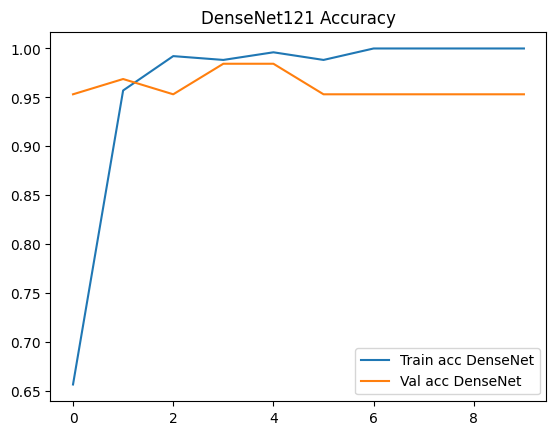

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Confusion Matrix:
[[19  0  0  0]
 [ 0 19  0  0]
 [ 0  0 13  0]
 [ 1  0  0 12]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           2       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        13
           9       1.00      0.92      0.96        13

    accuracy                           0.98        64
   macro avg       0.99      0.98      0.98        64
weighted avg       0.99      0.98      0.98        64



In [ ]:
# Plot the learning curves for DenseNet121
# This helps visualize how the training and validation accuracy evolve over epochs
plt.plot(history_densenet.history['accuracy'], label='Train acc DenseNet')
plt.plot(history_densenet.history['val_accuracy'], label='Val acc DenseNet')
plt.legend()
plt.title("DenseNet121 Accuracy")
plt.show()

# Evaluate the model on the validation dataset using a confusion matrix and classification report

# Initialize empty lists to store true labels and predictions
y_true = []
y_pred = []

# Loop through the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    preds = densenet_model.predict(images)

    # Append true labels
    y_true.extend(labels.numpy())

    # Convert predicted probabilities to class labels
    y_pred.extend(np.argmax(preds, axis=1))

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Print the classification report including precision, recall, and F1-score for each class
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))



# III-Comparison Between Custom CNN and DenseNet121
We compared the performance of a custom CNN and a DenseNet121 model pretrained on ImageNet.

### Accuracy:
- The custom CNN reached about **88% accuracy** on the validation set.
- DenseNet121 achieved an accuracy of **98%**, showing significantly better generalization.

### Confusion Matrix:
- The CNN showed several misclassifications, particularly between classes 2 and 4.
- DenseNet121 made only one error across all classes, with perfect classification on 3 out of 4 classes.

### Learning Curves:
- DenseNet121 reached high performance within very few epochs, showing faster and more stable convergence.
- It also showed less overfitting compared to the CNN, likely due to the use of pretrained features.

### Conclusion:
DenseNet121 clearly outperformed the custom CNN in terms of accuracy, robustness, and training efficiency.
This highlights the strong advantage of transfer learning when using deep models trained on large datasets like ImageNet.


## Which model is better?

After training both models and evaluating them on the validation dataset, we can conclude that the DenseNet121 model performs significantly better than the custom CNN.

DenseNet121 achieved a validation accuracy of 98%, compared to 88% for the custom CNN. It also showed better precision, recall, and F1-score across all classes, with only one misclassification in total. In contrast, the custom CNN made several errors, especially between class 2 and class 4.

In terms of overfitting, the custom CNN started to show signs of it after a few epochs, while DenseNet121 remained stable and generalized well to the validation data. This is likely because DenseNet121 benefits from transfer learning and pretrained weights on ImageNet, which help extract more meaningful features.

In summary, DenseNet121 is more accurate, more stable, and more efficient. It is clearly the better model for this classification task.


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the test image
img_path = '/content/drive/MyDrive/2023_2024/test.jpg'
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# For DenseNet, use its specific preprocessing
img_array_densenet = preprocess_input(np.copy(img_array))

# Predict with the custom CNN
pred_cnn = model.predict(img_array)
pred_class_cnn = class_names[np.argmax(pred_cnn)]

# Predict with DenseNet121
pred_densenet = densenet_model.predict(img_array_densenet)
pred_class_densenet = class_names[np.argmax(pred_densenet)]

# Show predictions
print("Custom CNN Prediction:", pred_class_cnn)
print("DenseNet121 Prediction:", pred_class_densenet)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Custom CNN Prediction: 4
DenseNet121 Prediction: 2


## Prediction on test.jpg – Is the result satisfactory?

The image `test.jpg` was classified differently by the two models:

- The **custom CNN predicted class 4**
- The **DenseNet121 model predicted class 2**

This disagreement reflects the overall performance observed earlier: the custom CNN was less accurate and more prone to confusion, especially between classes 2 and 4. DenseNet121, on the other hand, consistently demonstrated better generalization and higher precision.

Since class 2 and class 4 were already frequently confused by the CNN during validation, it is reasonable to **trust DenseNet121's prediction** in this case. The prediction is therefore **satisfactory**, considering it comes from the more reliable model.

In real applications, additional validation or human supervision may be required when models disagree, but here, DenseNet121’s robustness makes its prediction the most credible.
